In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# For saving dictionaries
import pickle

# Data visualization
import matplotlib.pyplot as plt

# For neural networks
import torch

# Computation of asset metrics
from portfolio_stats import PortfolioStats

# Time series splitting for walk forward modeling
from sklearn.model_selection import TimeSeriesSplit

# Neural network portfolio optimizer and objective functions
from workflow.tools.leverage_models import LSTMPortOpt_L, CNNPortOpt_L, FCNPortOpt_L
from workflow.tools.metrics import neg_sharpe_ratio

# Tensor transform
from workflow.tools.conversion import to_tensors

from workflow.tools.utils import set_plot_style, strftime

set_plot_style()

In [2]:
# Load data
kwargs = {
    "index_col": 0,
    "parse_dates": True
}

features = pd.read_csv("workflow/data/features.csv", **kwargs)

features.head()

,BONDS,COMMODITIES,STOCKS,VOLATILIITY,BONDS_RET,COMMODITIES_RET,STOCKS_RET,VOLATILIITY_RET
Date,,,,,,,,
2006-02-07,58.516796,21.282080,44.861336,13.59,-0.000699,-0.029352,-0.009784,0.041313
2006-02-08,58.487652,21.191517,45.184078,12.83,-0.000498,-0.004264,0.007168,-0.057548
2006-02-09,58.522652,21.390755,45.098019,13.12,0.000598,0.009358,-0.001906,0.022352
2006-02-10,58.399944,21.001339,45.191254,12.87,-0.002099,-0.018373,0.002065,-0.019239
2006-02-13,58.440830,20.675316,44.986858,13.35,0.000700,-0.015646,-0.004533,0.036617


In [3]:
# Define lookback window
lookback = 50
n_samples = len(features) - lookback
n_features = len(features.columns)

# Get columns related to returns, and index names
return_cols = [col for col in features.columns if "RET" in col]
indices = features.columns[~features.columns.isin(return_cols)]

# Initialize input data with zeros
X_ = np.zeros((n_samples, lookback, n_features))

# Extract target values starting from the lookback index
y = features[return_cols].iloc[lookback:].values

# Populate the 'X' tensor using a rolling window of size 'lookback'
for i in range(lookback, len(features)):
    X_[i-lookback] = features.iloc[i-lookback:i]

X_.shape, y.shape

((4403, 50, 8), (4403, 4))

In [4]:
# Set random seed (torch) for reproducibility
torch.manual_seed(42)

# Initialize models dictionary
models = {
    "FCN": FCNPortOpt_L,
    "CNN": CNNPortOpt_L,
    "LSTM": LSTMPortOpt_L,
}

# Initialize empty weights dictionary
weights = {model: [] for model in models.keys()}

# Define number of trading days per year and initialize TimeSeriesSplit
days_in_year = 365
trading_days = 252
retrain_after = 2
tss = TimeSeriesSplit(test_size=trading_days*retrain_after)
val_size = .2 # 20% validation window

# Loop over model
for a, (name, model_) in enumerate(models.items()):
    
    print(f"{a+1}: {name} ---", end="\n")

    # Vary input dimensions based on NN architecture
    if name == "CNN": 
        X = X_.transpose(0, 2, 1)
        input_size = X.shape[1]
    if name == "FCN": 
        X = X_.reshape((X_.shape[0], -1))
        input_size = X.shape[-1]
    if name == "LSTM": 
        X = X_
        input_size = X.shape[-1]

    dates = features.index
    test_start = None

    # Walk forward model training and prediction    
    for e, (train_idx, test_idx) in enumerate(tss.split(X)):
        
        train_start, train_end = strftime(dates[train_idx][0]), strftime(dates[train_idx][-1])
        
        if e == 0:
            test_start = dates[test_idx][0]
        
        val_idx = int(len(train_idx) * (1 - val_size))
        
        # Split data
        X_train, X_val, X_test = X[:val_idx], X[val_idx:], X[test_idx]
        y_train, y_val, y_test = y[:val_idx], y[val_idx:], y[test_idx]

        # Convert inputs and targets to PyTorch tensors
        X_train, X_val, X_test, y_train, y_val, y_test = to_tensors(
            X_train, X_val, X_test, y_train, y_val, y_test
        )

        # Hidden dimension and output dimension
        hidden_size = 64                       # 64 neurons
        output_size = y_train.shape[-1]        # 4 assets

        # Initialize model and optimizer
        model = model_(input_size, hidden_size, output_size)
        optimizer = torch.optim.Adam(model.parameters())

        # Define number of epochs
        epochs = 100

        # Construct training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            obj = neg_sharpe_ratio(outputs, y_train)
            obj.backward()
            optimizer.step()

            # Evaluate validation performance
            with torch.no_grad():
                val_allocations = model(X_val)
                val_obj = neg_sharpe_ratio(val_allocations, y_val)
            
            print(
                f"Split {e+1} ({train_start} - {train_end}): Epoch {epoch + 1}/{epochs} ({(epoch + 1)/epochs*100:,.2f}%)",
                "|",
                f"T: {-obj.item():,.5f}", 
                f"V: {-val_obj.item():,.5f}" ,
                end="\r"
            )

        print()
        
        # Get the outputs (asset allocations) after training
        with torch.no_grad():
            model_allocations = model(X_test)
            weights[name].append(model_allocations)
    
    print()
    print(f"Test Period: {strftime(test_start)} - {strftime(dates[-1])}")
    print(f"Test Period Duration: {(dates[-1] - test_start).days / days_in_year:,.2f} years")
    print()

1: FCN ---
Split 1 (02/07/2006 - 07/31/2013): Epoch 100/100 (100.00%) | T: 0.22450 V: 0.09641
Split 2 (02/07/2006 - 07/31/2015): Epoch 100/100 (100.00%) | T: 0.24478 V: 0.06070
Split 3 (02/07/2006 - 08/01/2017): Epoch 100/100 (100.00%) | T: 0.14537 V: 0.11294
Split 4 (02/07/2006 - 08/02/2019): Epoch 100/100 (100.00%) | T: 1.55437 V: 0.51836
Split 5 (02/07/2006 - 08/03/2021): Epoch 100/100 (100.00%) | T: 0.64212 V: 0.37962

Test Period: 08/01/2013 - 10/16/2023
Test Period Duration: 10.21 years

2: CNN ---
Split 1 (02/07/2006 - 07/31/2013): Epoch 100/100 (100.00%) | T: 0.18872 V: 0.10087
Split 2 (02/07/2006 - 07/31/2015): Epoch 100/100 (100.00%) | T: 0.18888 V: 0.35286
Split 3 (02/07/2006 - 08/01/2017): Epoch 100/100 (100.00%) | T: 0.14610 V: 0.11281
Split 4 (02/07/2006 - 08/02/2019): Epoch 100/100 (100.00%) | T: 0.57328 V: 0.51824
Split 5 (02/07/2006 - 08/03/2021): Epoch 100/100 (100.00%) | T: 1.73982 V: 0.01685

Test Period: 08/01/2013 - 10/16/2023
Test Period Duration: 10.21 years

3:

In [5]:
# Backtest optimized portfolios
backtest = []
weights_dfs = {model: None for model in models.keys()}

# Set loan variables
loan_term = 2     # 2Y repayment schedule
loan_ir = 0.05    # 5% interest rate
days_in_year = 365

amrtzn = 1 / (days_in_year * loan_term)
ir = loan_ir / days_in_year

# Set transaction variables
trnsc_cr = 0.002  # 0.2% transaction cost rate

for name, weights_ in weights.items():
    weights_concat = np.concatenate(weights_)
    
    # Reindex features to match weights
    reindexed_features = features.iloc[-len(weights_concat):]
    weights_df = pd.DataFrame(weights_concat, index=reindexed_features.index, columns=indices)

    # Shift weights for real time information lag
    weights_df = weights_df.shift().dropna()

    reindexed_returns = reindexed_features[return_cols][1:]
    reindexed_returns.columns = indices

    # Portfolio returns = sum of (weights * returns)
    returns = (weights_df * reindexed_returns).sum(axis=1)

    # Account for transaction costs
    c = weights_df.diff().abs().sum(axis=1)
    tc = c * trnsc_cr
    returns = returns - tc
    
    # Account for principal repayment and borrowing costs
    lvg = (weights_df.sum(axis=1) - 1)
    bc = (lvg * ir).diff()
    pr = (lvg * amrtzn).diff()
    returns = returns - bc - pr
    
    returns.name = name
    backtest.append(returns)

    weights_dfs[name] = weights_df

backtest = pd.concat(backtest, axis=1)
backtest["STOCK_MARKET"] = features[return_cols].reindex(backtest.index)["STOCKS_RET"]
backtest.loc[backtest.index.min()] = 0

backtest.head()

,FCN,CNN,LSTM,STOCK_MARKET
Date,,,,
2013-10-14,0.000000,0.000000,0.000000,0.000000
2013-10-15,0.137849,0.141298,0.012109,-0.007662
2013-10-16,-0.211982,-0.219630,-0.017757,0.013928
2013-10-17,-0.082540,-0.077193,-0.001897,0.007335
2013-10-18,-0.018723,-0.024452,0.002898,0.007062


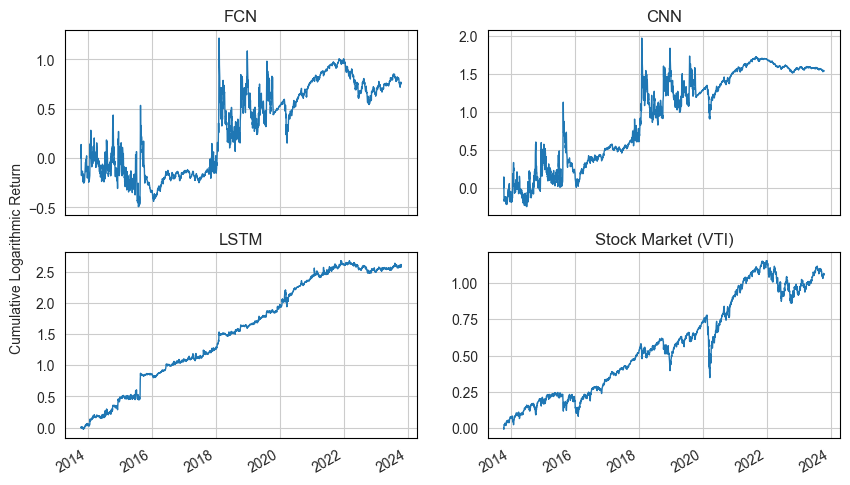

In [6]:
# Plot equity curves
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
axes = axes.flatten()
titles = ["FCN", "CNN", "LSTM", "Stock Market (VTI)"]

for i, (ax, col) in enumerate(zip(axes, backtest.columns)):
    ax.set_title(titles[i])
    backtest[col].cumsum().plot(ax=ax)
    ax.set_xlabel("")

fig.text(0.07, 0.5, 'Cumulative Logarithmic Return', va='center', rotation='vertical')
plt.show()

In [7]:
backtest.to_csv("workflow/data/backtests/lstm_lev_bt.csv")
with open("workflow/data/optimizations/lstm_lev_opt.pkl", "wb") as f:
    pickle.dump(weights_dfs, f)

In [8]:
optimized_stats = PortfolioStats(backtest, log=True)

optimized_stats.info.sort_values(by="SHARPE", ascending=False)

,SHARPE,CUMU_RET,ANN_RET,ANN_VOL,MAX_DD
LSTM,1.119602,2.587803,0.258883,0.231228,-0.267159
STOCK_MARKET,0.594404,1.063772,0.106419,0.179036,-0.430787
CNN,0.196432,1.538755,0.153937,0.783665,-1.14846
FCN,0.097528,0.759016,0.075932,0.778561,-1.148626


In [9]:
for col in optimized_stats.info.columns:
    print("--", col, "--")
    print(optimized_stats.info[col].sort_values(ascending=False)[:1])
    print()

-- SHARPE --
LSTM    1.119602
Name: SHARPE, dtype: object

-- CUMU_RET --
LSTM    2.587803
Name: CUMU_RET, dtype: object

-- ANN_RET --
LSTM    0.258883
Name: ANN_RET, dtype: object

-- ANN_VOL --
CNN    0.783665
Name: ANN_VOL, dtype: object

-- MAX_DD --
LSTM   -0.267159
Name: MAX_DD, dtype: object



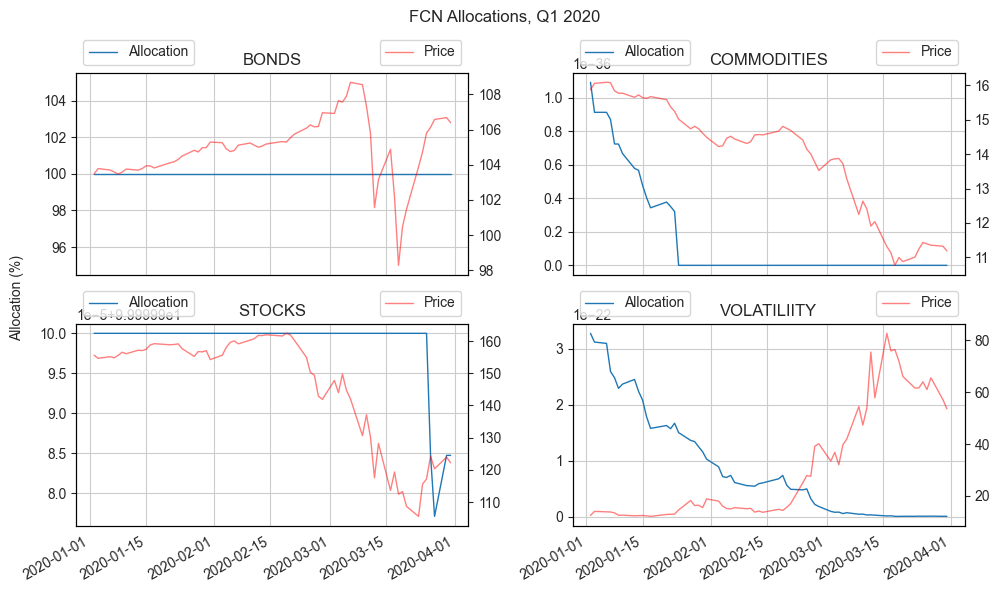

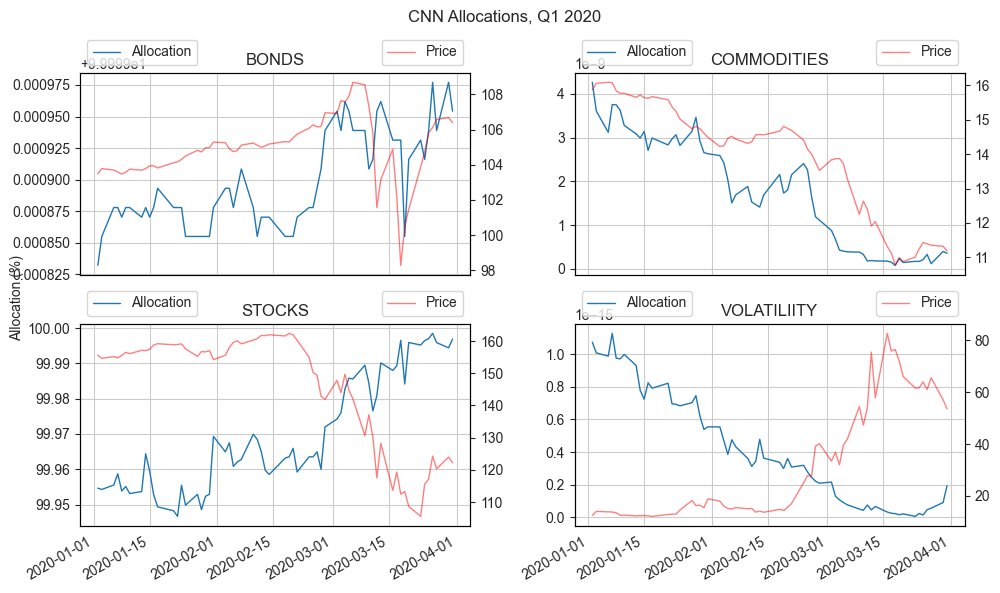

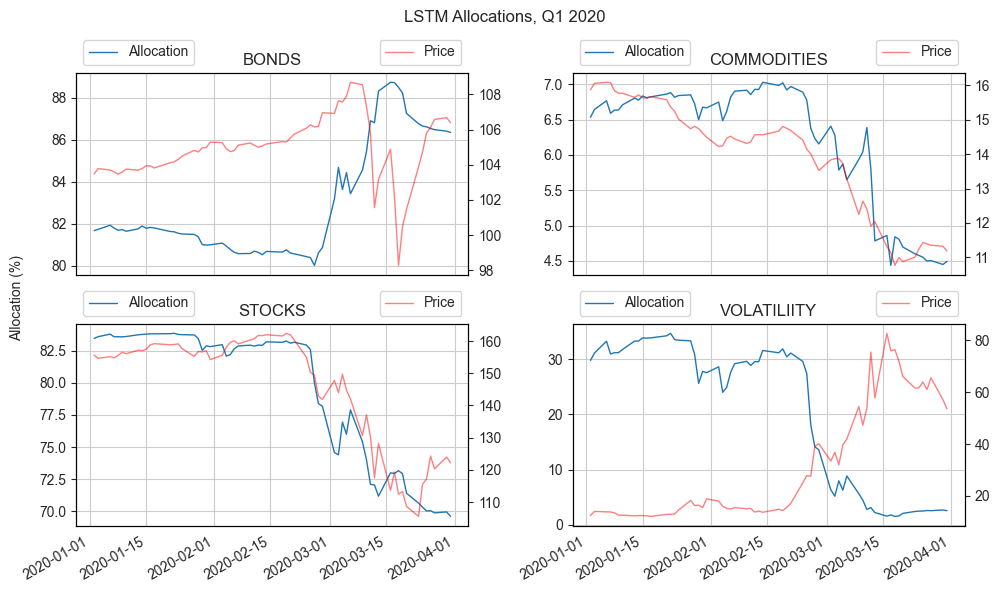

In [15]:
# Plot Q1 2020 (COVID-19) market crash allocations
covid_q1 = {"start": "2020-01", "end": "2020-03"}

for strat in weights.keys():

    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
    fig.suptitle(f"{strat} Allocations, Q1 2020", fontsize=12)

    axes = axes.flatten()
    
    for ax, index in zip(axes, indices):

        ax.set_title(index)
        ax_twin = ax.twinx()
        index_allocation = weights_dfs[strat][index]

        date_allocation = index_allocation.loc[covid_q1["start"]:covid_q1["end"]] * 100
        prices = features[indices].loc[covid_q1["start"]:covid_q1["end"]]

        date_allocation.plot(ax=ax)
        prices[index].plot(ax=ax_twin, grid=False, color="r", alpha=.5)

        ax.set_xlabel("")
        ax.legend(["Allocation"], loc='upper left', bbox_to_anchor=(0,1.2))
        ax_twin.legend(["Price"], loc='upper right', bbox_to_anchor=(1,1.2))

    fig.text(0.005, 0.5, 'Allocation (%)', va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()

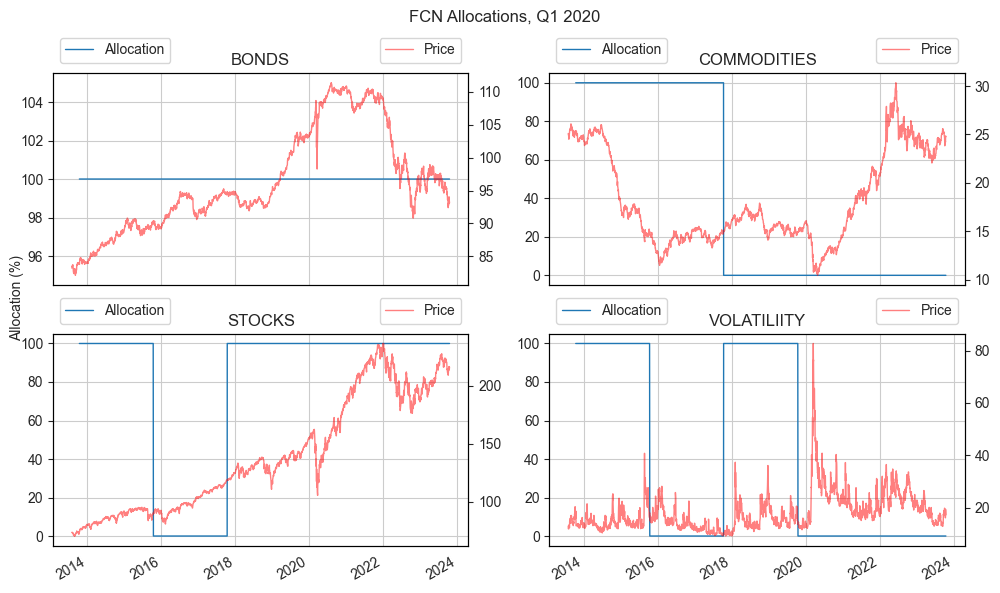

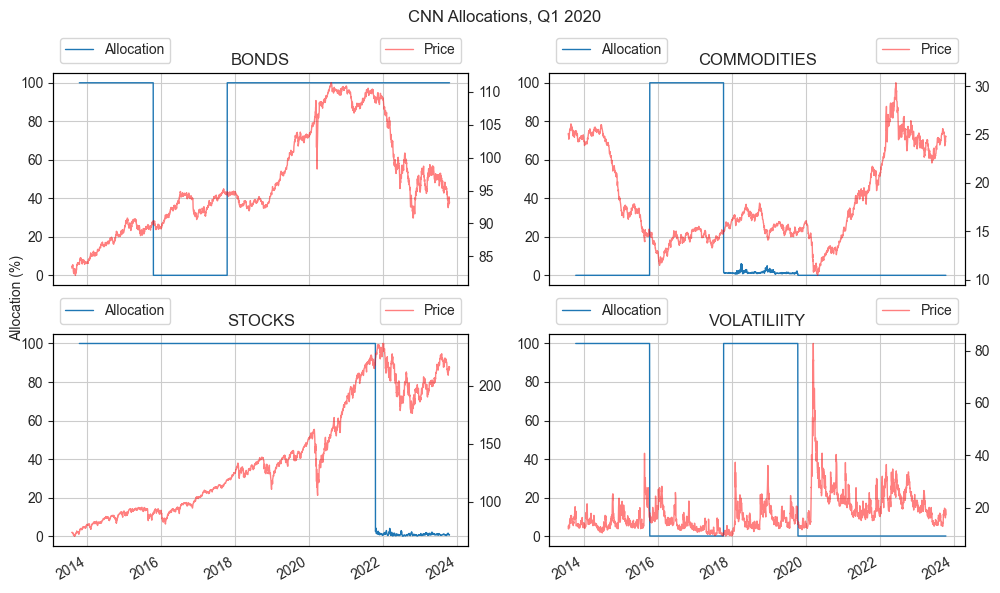

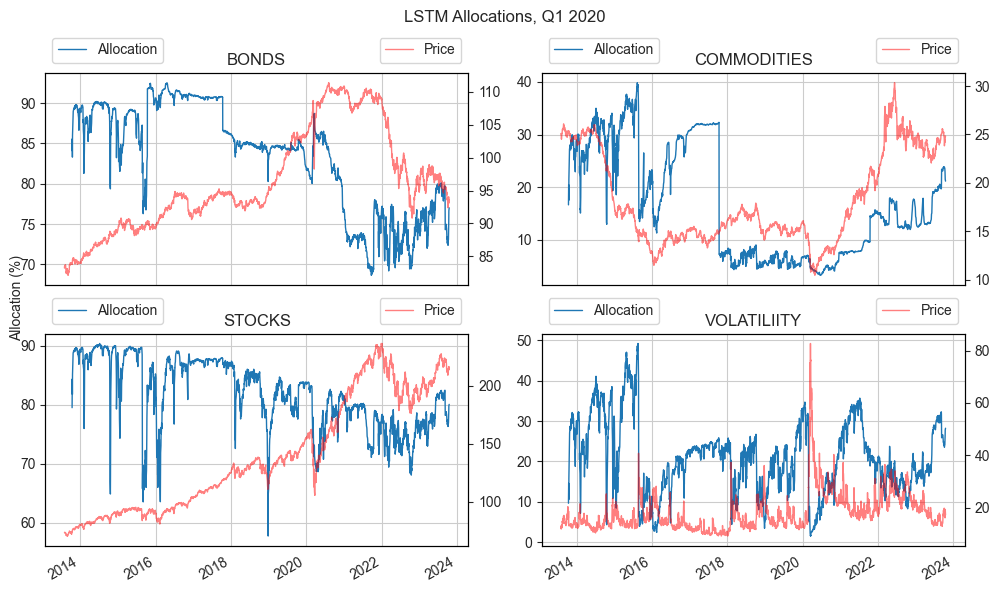

In [17]:
# Plot the entirety of the allocations against price trajectories
for strat in weights.keys():

    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
    fig.suptitle(f"{strat} Allocations, Q1 2020", fontsize=12)

    axes = axes.flatten()
    
    for ax, index in zip(axes, indices):

        ax.set_title(index)
        ax_twin = ax.twinx()
        index_allocation = weights_dfs[strat][index]

        all_allocations = index_allocation.loc[test_start:] * 100
        prices = features[indices].loc[test_start:]

        all_allocations.plot(ax=ax)
        prices[index].plot(ax=ax_twin, grid=False, color="r", alpha=.5)

        ax.set_xlabel("")
        ax.legend(["Allocation"], loc='upper left', bbox_to_anchor=(0,1.2))
        ax_twin.legend(["Price"], loc='upper right', bbox_to_anchor=(1,1.2))

    fig.text(0.005, 0.5, 'Allocation (%)', va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()

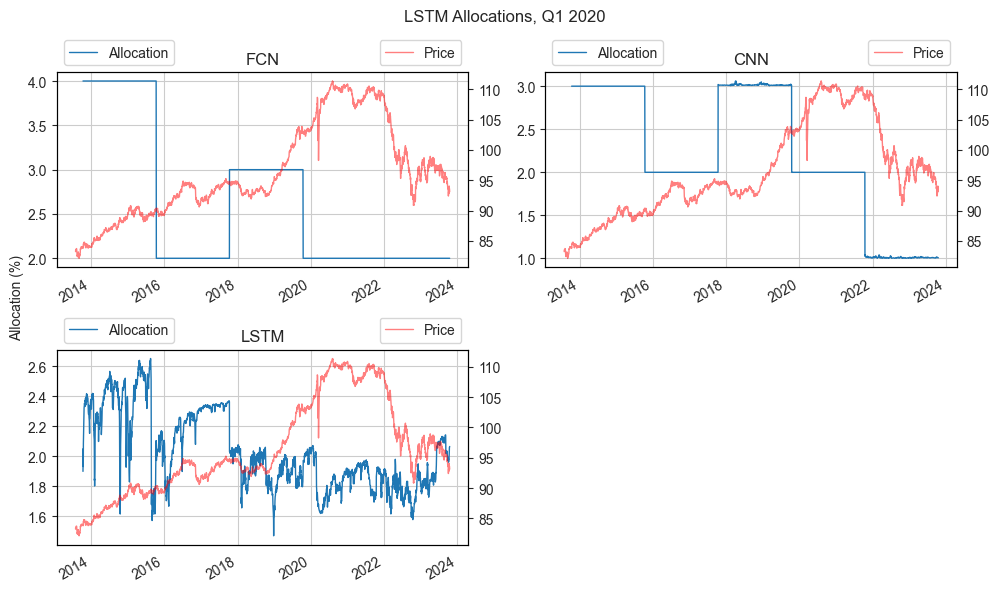

In [26]:
# Plot the entirety of the allocations against price trajectories

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle(f"{strat} Allocations, Q1 2020", fontsize=12)
axes = axes.flatten()
    
for ax, strat in zip(axes, weights_dfs.keys()):

    ax.set_title(strat)
    ax_twin = ax.twinx()
    pct_port_invested = weights_dfs[strat].loc[test_start:].sum(axis=1)
    prices = features[indices].loc[test_start:]

    pct_port_invested.plot(ax=ax)
    prices[index].plot(ax=ax_twin, grid=False, color="r", alpha=.5)

    ax.set_xlabel("")
    ax.legend(["Allocation"], loc='upper left', bbox_to_anchor=(0,1.2))
    ax_twin.legend(["Price"], loc='upper right', bbox_to_anchor=(1,1.2))

fig.text(0.005, 0.5, 'Allocation (%)', va='center', rotation='vertical')
axes[-1].axis("off")
plt.tight_layout()
plt.show()

In [11]:
# Inspect max and min leverage values and dates for each model
for i, (strat, allocations) in enumerate(weights_dfs.items()):
    print(f"""{strat} 
Maximum Leverage:\t{allocations.sum(axis=1).max():,.2f}x
Date:\t\t\t{allocations.sum(axis=1).idxmax().strftime("%b %d, %Y")}
Minimum Leverage:\t{allocations.sum(axis=1).min():,.2f}x
Date:\t\t\t{allocations.sum(axis=1).idxmin().strftime("%b %d, %Y")}
          """)

FCN 
Maximum Leverage:	4.00x
Date:			Oct 14, 2013
Minimum Leverage:	2.00x
Date:			May 06, 2020
          
CNN 
Maximum Leverage:	3.06x
Date:			Apr 04, 2018
Minimum Leverage:	1.00x
Date:			Aug 05, 2022
          
LSTM 
Maximum Leverage:	2.65x
Date:			Aug 18, 2015
Minimum Leverage:	1.47x
Date:			Dec 27, 2018
          
